In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint

# Set random seed
random_seed = 36

### Closed World Dataset model training

## Background
The Darknet dataset contains metrics measured from packet captures detailing diffirent types of traffic. It includes A mix of VPN, Tor, and regular traffic and we want to train a model to classify these different types of traffic.

## Setup
- We are loading the dataset in and splitting it into training and testing sets
- X is the features ('Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Bwd Init Win Bytes', 'FWD Init Win Bytes')
- y is the class ('Tor Traffic', 'other')
- using the train_test_split function we can easily split the data into training and testing cases 

In [2]:
darknet_data = pd.read_csv('allTraffic.csv')

# Drop columns that aren't useful to us
features = ['FlowDuration', 'TotalFwdPackets', 'TotalBwdPackets', 'BwdInitWinBytes', 'FwdInitWinBytes']
dim = len(features)
X = darknet_data[features]
y = darknet_data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [3]:
# Define the hyperparameter space (possible values to try for each hyperparameter)
param_dist = {
                'n_estimators': randint(50,500),
                'max_depth': randint(1,20),
             }

# Train a Random Forest classifier
# if we wanted to optimize the hyperparameters, we could use a RandomizedSearchCV
# just define the classifier with no hyperparameters
# clf = RandomForestClassifier(n_estimators=460, max_depth=12, random_state=random_seed)
clf = RandomForestClassifier(random_state=random_seed)
rand_search = RandomizedSearchCV(clf,
                                 param_distributions=param_dist,
                                 n_iter=3,
                                 cv=3)



## Training 
1. First we define the algorithm we will use to train the model, in this case the RandomForestClassifier
2. Next we train the model with training sets 

In [4]:
from joblib import parallel_backend
with parallel_backend('threading'):
    # Fit the model to our training data
    rand_search.fit(X_train, y_train)

    # optimal hyperparameters
    best = rand_search.best_estimator_

    # Fit the optimal model to our training data
    best.fit(X_train, y_train)

In [5]:

# This line is if we want to use the RandomizedSearchCV to find the best hyperparameters
from joblib import parallel_backend
with parallel_backend('threading'):
    # Predict values of y_test on the X_test set
    y_pred = best.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy, "\n", classification_rep)


0.9239130434782609 
               precision    recall  f1-score   support

     Non-Tor       0.92      0.99      0.95        73
         Tor       0.93      0.68      0.79        19

    accuracy                           0.92        92
   macro avg       0.93      0.84      0.87        92
weighted avg       0.92      0.92      0.92        92


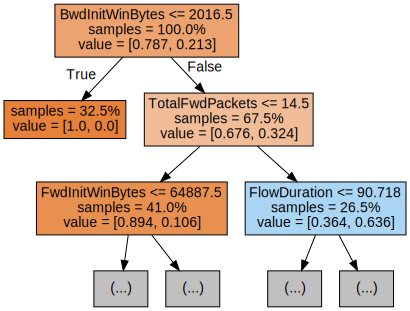

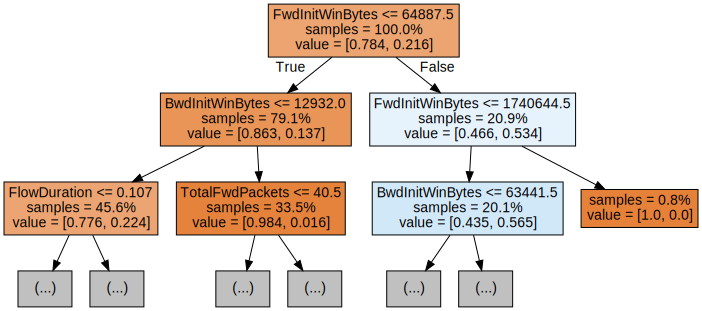

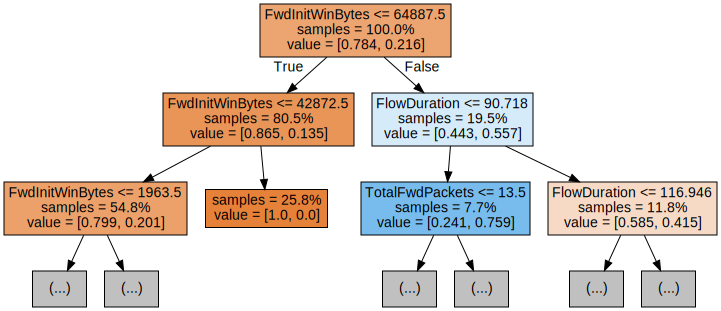

In [6]:
from sklearn.tree import export_graphviz
import graphviz
import pickle

# Save the model to disk uncomment to save it
# filename = 'darknet_model.sav'
# pickle.dump(clf, open(filename, 'wb'))

# Plot the decision trees
for i in range(3):
    tree = best.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)